# 01. Import librairies + Dataset + Trained Model

In [2]:
!pip install tensorflow

     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ----------------------------------- ---- 41.0/46.2 kB 2.0 MB/s eta 0:00:01
     ----------------------------------- ---- 41.0/46.2 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 46.2/46.2 kB 386.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/377.0 MB 656.4 kB/s eta 0:09:35
   ---------------------------------------- 0.2/377.0 MB 1.1 MB/s eta 0:05:29
   ---------------------------------------- 0.2/377.0 MB 1.4 MB/s eta 0:04:34
   ---------------------------------------- 0.3/377.0 MB 1.4 MB/s eta 0:04:36
   ---------------------------------------- 0.3/377.0 MB 1.4 MB/s eta 0:04:28
   ---------------------------------------- 0.3/377.0 MB 1.4 MB/s eta 0:04:28
   ---------------------------------------- 0.5/377.0 MB 1.5 MB/s eta 0:04:1

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Datasets/data.csv')

In [7]:
!pip install -q keras-tcn --no-dependencies

In [8]:
import pandas as pd
import numpy as np

from keras.models import Model
from keras.layers import Input, Dense
from tcn import TCN, tcn_full_summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
import matplotlib.pyplot as plt

In [10]:
import statsmodels.api as sm

In [11]:
# data = pd.read_csv('data.csv')
data.head()

,Id,humidity,temperature,humiditysol,temperaturesol,co2,lumière,date
0,2,73.4,24.2,0,10,71.82,0,2022-04-18 12:54:36
1,3,80.7,24.2,8,10,47.17,0,2022-04-18 12:55:36
2,4,90.5,24.1,3,10,113.27,1,2022-04-18 12:56:36
3,5,0.0,0.0,7,10,44.00,1,2022-04-18 12:57:38
4,6,85.6,25.7,6,10,101.62,1,2022-04-18 12:58:38


In [12]:
data = data[['humidity', 'temperature', 'date']]
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head()

<ipython-input-12-4b471ef18d17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


,humidity,temperature
date,,
2022-04-18 12:54:36,73.4,24.2
2022-04-18 12:55:36,80.7,24.2
2022-04-18 12:56:36,90.5,24.1
2022-04-18 12:57:38,0.0,0.0
2022-04-18 12:58:38,85.6,25.7


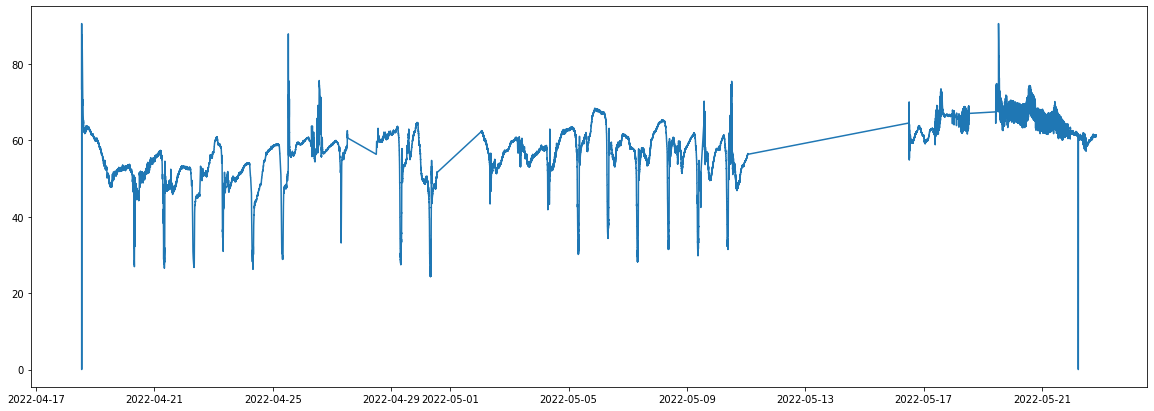

In [13]:
plt.figure(figsize=(20,7))
plt.plot(data['humidity'])
plt.show()

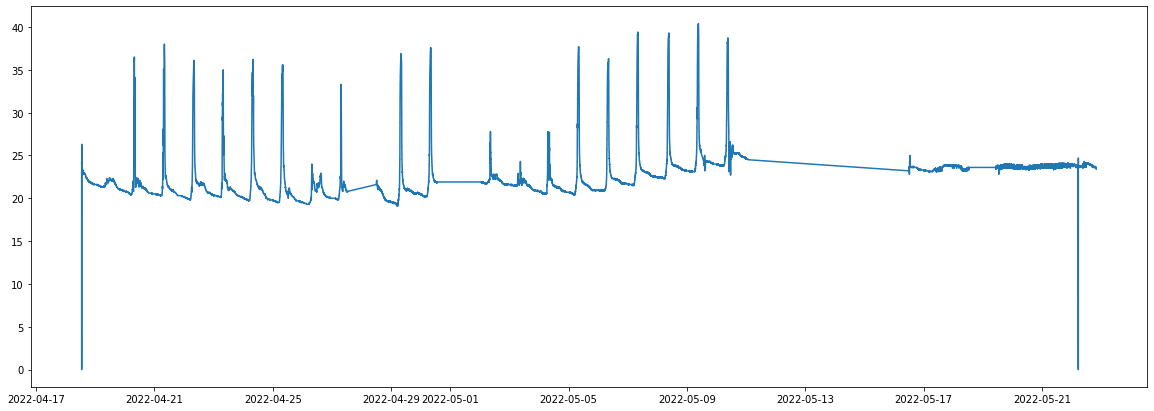

In [14]:
plt.figure(figsize=(20,7))
plt.plot(data['temperature'])
plt.show()

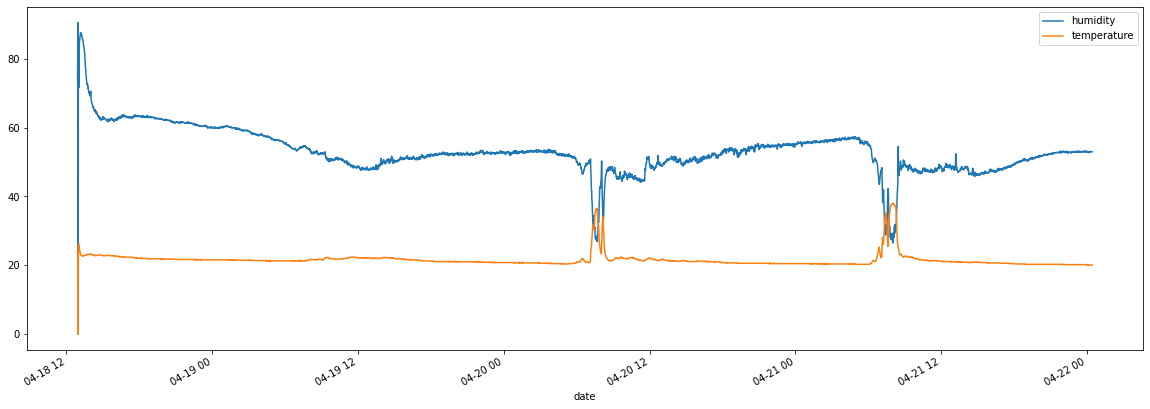

In [15]:
data.iloc[:5000,:].plot(figsize=(20, 7))

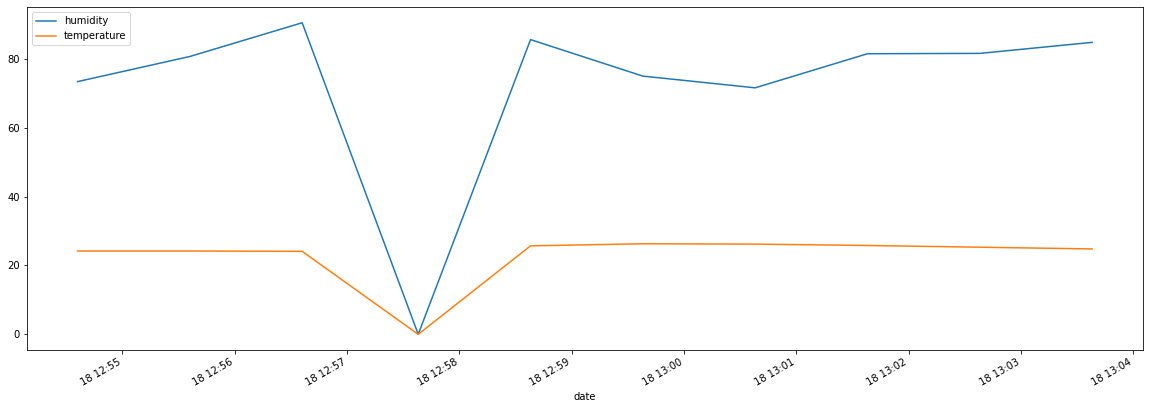

In [16]:
data.iloc[:10,:].plot(figsize=(20, 7))

In [17]:
data.iloc[:10,:].index

DatetimeIndex(['2022-04-18 12:54:36', '2022-04-18 12:55:36',
               '2022-04-18 12:56:36', '2022-04-18 12:57:38',
               '2022-04-18 12:58:38', '2022-04-18 12:59:38',
               '2022-04-18 13:00:38', '2022-04-18 13:01:38',
               '2022-04-18 13:02:38', '2022-04-18 13:03:38'],
              dtype='datetime64[ns]', name='date', freq=None)

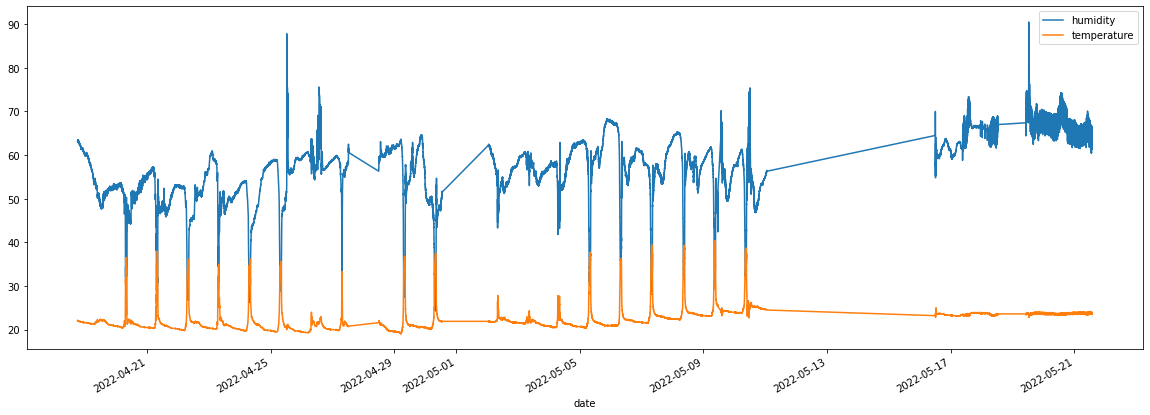

In [18]:
data.iloc[5*60:-30*60,:].plot(figsize=(20, 7))

In [19]:
data.index[0], data.index[-1]

(Timestamp('2022-04-18 12:54:36'), Timestamp('2022-05-22 19:56:35'))

In [20]:
data = data.iloc[5*60:-30*60,:]

In [21]:
data.index[0], data.index[-1]

(Timestamp('2022-04-18 18:04:30'), Timestamp('2022-05-21 13:56:01'))

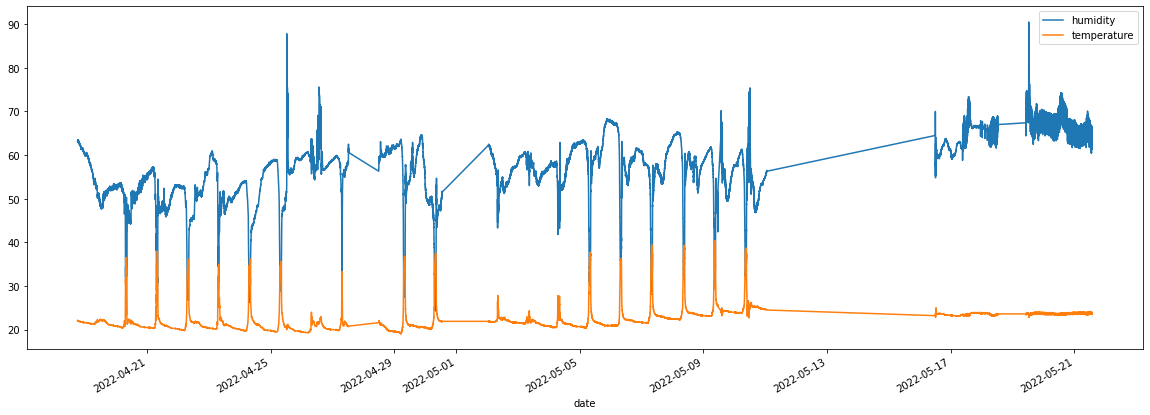

In [22]:
data.plot(figsize=(20, 7))

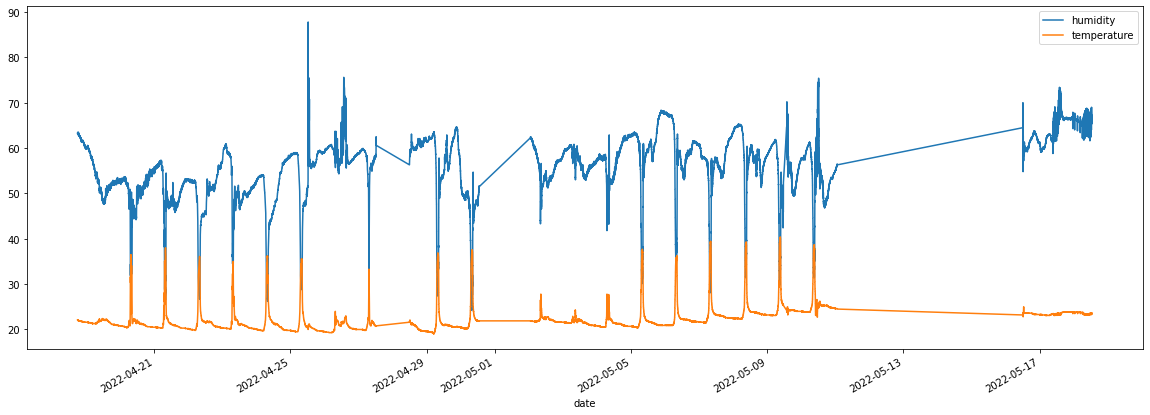

In [23]:
data[:'2022-05-18'].plot(figsize=(20, 7))

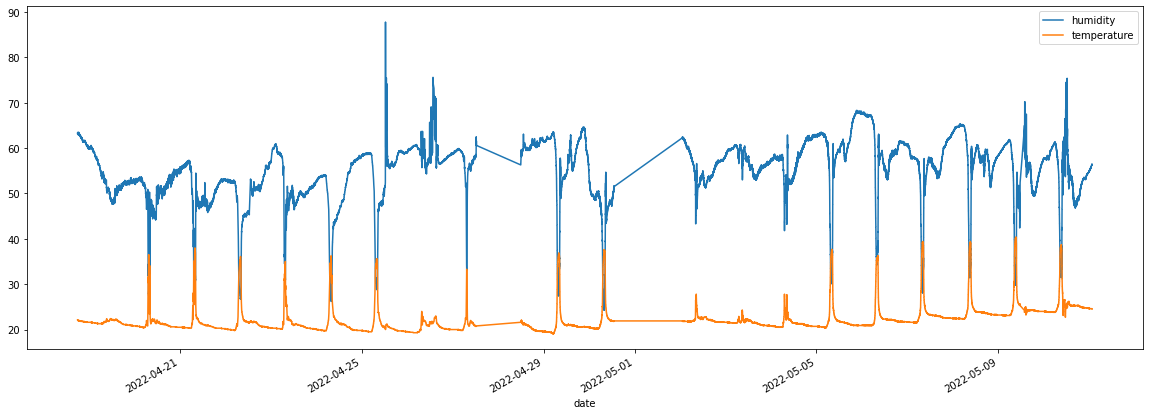

In [24]:
data[:'2022-05-12'].plot(figsize=(20, 7))

In [25]:
print(data.shape)
data = data[:'2022-05-12']
print(data.shape)

(945582, 2)
(939350, 2)


In [26]:
(945582 - 939350) / 945582

0.006590649991222337

In [27]:
(945582 - (945582 - 939350)) / 945582

0.9934093500087776

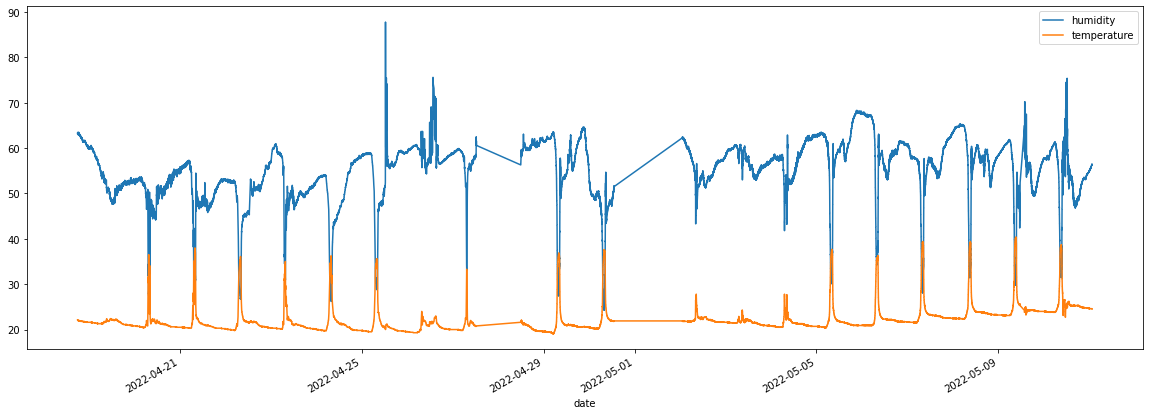

In [28]:
data.plot(figsize=(20, 7))

In [29]:
pd.DataFrame(data['humidity'].resample('T').max()).isna().sum()

humidity    3873
dtype: int64

In [30]:
data_resampled = pd.DataFrame(data.resample('T').max())

In [31]:
data_resampled.shape

(32123, 2)

In [32]:
data_resampled.isna().sum()

humidity       3873
temperature    3873
dtype: int64

Il existe plusieurs façons de gérer les valeurs manquantes dans les séries chronologiques avant de les utiliser pour entraîner un modèle TCN.

nous, on va utiliser ici une technique qui me ressemble plus raisonable, `Interpolation`, qui est une technique d'interpolation pour estimer les valeurs manquantes en utilisant les valeurs avant et après la valeur manquante.

In [33]:
data_resampled

,humidity,temperature
date,,
2022-04-18 18:04:00,63.3,22.1
2022-04-18 18:05:00,63.1,22.0
2022-04-18 18:06:00,63.2,22.1
2022-04-18 18:07:00,63.3,22.0
2022-04-18 18:08:00,63.2,22.0
...,...,...
2022-05-11 01:22:00,56.4,24.6
2022-05-11 01:23:00,56.4,24.6
2022-05-11 01:24:00,56.4,24.6


In [34]:
sum(data_resampled.isna().values)

array([3873, 3873])

In [35]:
49383 - 13017

36366

In [36]:
data_resampled[~data_resampled.isna().values].isna().sum()

humidity       0
temperature    0
dtype: int64

In [37]:
data_resampled[data_resampled.isna().values]

,humidity,temperature
date,,
2022-04-19 20:52:00,NaN,NaN
2022-04-19 20:52:00,NaN,NaN
2022-04-21 12:22:00,NaN,NaN
2022-04-21 12:22:00,NaN,NaN
2022-04-22 01:06:00,NaN,NaN
...,...,...
2022-05-09 13:41:00,NaN,NaN
2022-05-09 13:42:00,NaN,NaN
2022-05-09 13:42:00,NaN,NaN


In [38]:
data_resampled.interpolate(method='linear', inplace=True)

In [39]:
data_resampled[data_resampled.isna().values]

,humidity,temperature
date,,


voilà la première ligne remplit par des valeurs estimer par la technique d'interpolation. 

In [40]:
data_resampled.loc['2022-04-18 20:52:00']

humidity       61.3
temperature    21.8
Name: 2022-04-18 20:52:00, dtype: float64

et voilà la ligne précedente.

In [41]:
data_resampled.loc['2022-04-18 20:51:00']

humidity       61.5
temperature    21.8
Name: 2022-04-18 20:51:00, dtype: float64

et la ligne suivante

In [42]:
sum(data_resampled.isna().values)

array([0, 0])

In [43]:
data_resampled

,humidity,temperature
date,,
2022-04-18 18:04:00,63.3,22.1
2022-04-18 18:05:00,63.1,22.0
2022-04-18 18:06:00,63.2,22.1
2022-04-18 18:07:00,63.3,22.0
2022-04-18 18:08:00,63.2,22.0
...,...,...
2022-05-11 01:22:00,56.4,24.6
2022-05-11 01:23:00,56.4,24.6
2022-05-11 01:24:00,56.4,24.6


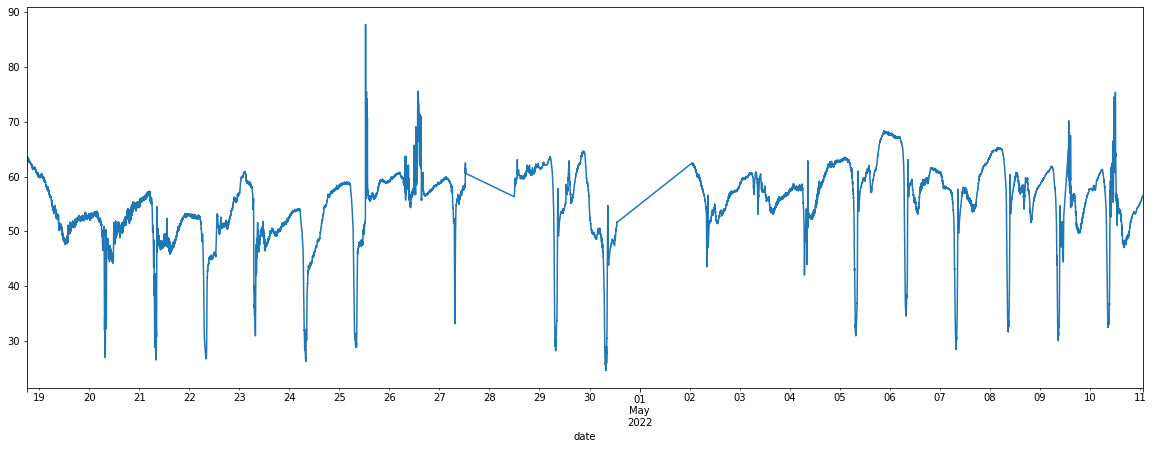

In [44]:
data_resampled['humidity'].plot(figsize=(20, 7))

In [45]:
data_resampled.asfreq('T').isna().sum()

humidity       0
temperature    0
dtype: int64

In [46]:
# https://stackoverflow.com/questions/71982711/valueerror-this-function-does-not-handle-missing-values

In [47]:
data_resampled.index

DatetimeIndex(['2022-04-18 18:04:00', '2022-04-18 18:05:00',
               '2022-04-18 18:06:00', '2022-04-18 18:07:00',
               '2022-04-18 18:08:00', '2022-04-18 18:09:00',
               '2022-04-18 18:10:00', '2022-04-18 18:11:00',
               '2022-04-18 18:12:00', '2022-04-18 18:13:00',
               ...
               '2022-05-11 01:17:00', '2022-05-11 01:18:00',
               '2022-05-11 01:19:00', '2022-05-11 01:20:00',
               '2022-05-11 01:21:00', '2022-05-11 01:22:00',
               '2022-05-11 01:23:00', '2022-05-11 01:24:00',
               '2022-05-11 01:25:00', '2022-05-11 01:26:00'],
              dtype='datetime64[ns]', name='date', length=32123, freq='T')

In [48]:
# # perform seasonal decompose in a list comprehension on each column, return dataframe
# def season_decom(df, model='additive'):    
#     return pd.concat([pd.DataFrame({col: sm.tsa.seasonal_decompose(df[col], model=model).trend}) for col in df.columns], axis=1)

In [49]:
timeseries_data_len = len(data_resampled['humidity'].values)

In [50]:
data_resampled.index[0]

Timestamp('2022-04-18 18:04:00', freq='T')

In [51]:
from datetime import datetime

In [52]:
DatetimeIndex___ = pd.date_range(start=data_resampled.index[0], periods=timeseries_data_len, freq='T')

data_resampled_humidity = pd.DataFrame(data=data_resampled['humidity'].values, columns=['humidity'], index=DatetimeIndex___)
data_resampled_humidity

,humidity
2022-04-18 18:04:00,63.3
2022-04-18 18:05:00,63.1
2022-04-18 18:06:00,63.2
2022-04-18 18:07:00,63.3
2022-04-18 18:08:00,63.2
...,...
2022-05-11 01:22:00,56.4
2022-05-11 01:23:00,56.4
2022-05-11 01:24:00,56.4
2022-05-11 01:25:00,56.4


In [53]:
decompfreq = 6*12

In [54]:
# decomposition = sm.tsa.seasonal_decompose(data_resampled_humidity,freq=decompfreq)

In [55]:
# fig = decomposition.plot()
# fig.set_size_inches((20, 7))

# 02. Prepare Data

## 02/ 1. split into train and test sets

In [56]:
data.shape

(939350, 2)

In [57]:
data

,humidity,temperature
date,,
2022-04-18 18:04:30,63.3,22.1
2022-04-18 18:05:30,63.1,22.0
2022-04-18 18:06:30,63.2,22.1
2022-04-18 18:07:30,63.3,22.0
2022-04-18 18:08:30,63.2,22.0
...,...,...
2022-05-11 01:26:01,56.3,24.5
2022-05-11 01:26:02,56.3,24.5
2022-05-11 01:26:03,56.3,24.5


In [58]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size,:], data.iloc[train_size:len(data),:]
print(len(train), len(test))

704512 234838


In [59]:
train.shape, test.shape

((704512, 2), (234838, 2))

In [60]:
# normalize the time series
from sklearn.preprocessing import StandardScaler

# Initialiser l'objet StandardScaler
scaler = StandardScaler()

# Standardiser les données en utilisant la méthode fit_transform
train = scaler.fit_transform(train)

In [61]:
train

array([[ 0.90889142,  0.00963941],
       [ 0.87894627, -0.02513119],
       [ 0.89391884,  0.00963941],
       ...,
       [ 1.16342518,  0.11395122],
       [ 1.16342518,  0.11395122],
       [ 1.16342518,  0.11395122]])

In [62]:
test

,humidity,temperature
date,,
2022-05-08 05:05:22,65.0,22.4
2022-05-08 05:05:23,65.0,22.4
2022-05-08 05:05:24,65.0,22.4
2022-05-08 05:05:25,65.0,22.4
2022-05-08 05:05:26,65.0,22.4
...,...,...
2022-05-11 01:26:01,56.3,24.5
2022-05-11 01:26:02,56.3,24.5
2022-05-11 01:26:03,56.3,24.5


In [63]:
test = scaler.transform(test)

In [64]:
test

array([[ 1.16342518,  0.11395122],
       [ 1.16342518,  0.11395122],
       [ 1.16342518,  0.11395122],
       ...,
       [-0.13918878,  0.84413385],
       [-0.13918878,  0.84413385],
       [-0.13918878,  0.84413385]])

I set the look back date as 10 minutes, which is the number of previous time steps to use as input variables to predict the next time period

In [65]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [66]:
X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(704501, 10, 2) (704501, 2)
(234827, 10, 2) (234827, 2)


In [67]:
X_train[0]

array([[ 0.90889142,  0.00963941],
       [ 0.87894627, -0.02513119],
       [ 0.89391884,  0.00963941],
       [ 0.90889142, -0.02513119],
       [ 0.89391884, -0.02513119],
       [ 0.89391884,  0.00963941],
       [ 0.89391884, -0.02513119],
       [ 0.87894627, -0.02513119],
       [ 0.89391884,  0.00963941],
       [ 0.87894627, -0.02513119]])

# 03. Build TCN Model

In [64]:
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [65]:
import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [66]:
# if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.
batch_size, time_steps, input_dim = None, 10, 2


tcn_layer = TCN(input_shape=(time_steps, input_dim))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
    tcn_layer,
    Dense(2)
])

m.compile(optimizer='adam', loss=rmse)

tcn_full_summary(m, expand_residual_blocks=False)

h = m.fit(X_train, y_train, epochs=11, validation_split=0.2)

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/11
17613/17613 [==============================] - 144s 8ms/step - loss: 0.0285 - val_loss: 0.0091
Epoch 2/11
17613/17613 [==============================] - 142s 8ms/step - loss: 0.0113 - val_loss: 0.0093
Epoch 3/11
17613/17613 [==============================] - 134s 8ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 4/11
17613/17613 [==============================] - 132s 8ms/step - loss: 0.0098 - val_loss: 0.0109
Epoch 5/11
17613/17613 [==============================] - 131s 7ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 6/11
17613/17613 [==============================] - 138s 8ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 7/11
17613/17613 [==============================] - 132s 7ms/step - loss: 0.0091 - val_loss: 0.0073
Epoch 8/11
17613/17613 [==============================] - 131s 7ms/step - loss: 0.0090 - val_loss: 0.0095
Epoch 9/11
17613/17613 [=============================

In [67]:
m.save('/content/drive/MyDrive/Datasets/Analyse prédictive/TCN_Model_rmse_30_epochs_v2')

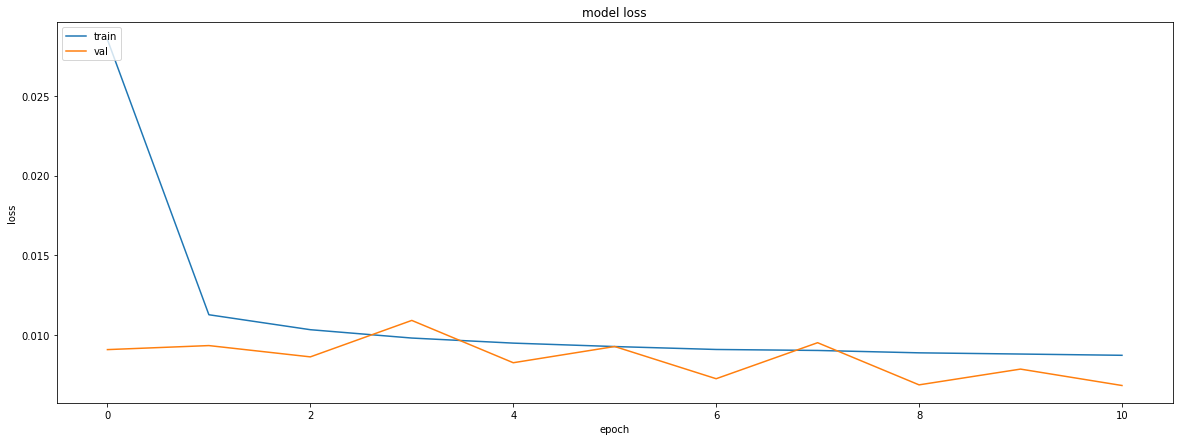

In [68]:
plt.figure(figsize=(20, 7))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
preds__test = m.predict(X_test)
preds__train = m.predict(X_train)

22016/22016 [==============================] - 65s 3ms/step


In [70]:
y_test.shape, preds__test.shape

((234827, 2), (234827, 2))

In [71]:
testset_rmse = rmse(y_test, preds__test)
trainset_rmse = rmse(y_train, preds__train)

In [72]:
float(testset_rmse), float(trainset_rmse)

(0.010919993236379991, 0.011688577063788229)

# 04. Predictions

In [4]:
from tensorflow import keras
import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# m = keras.models.load_model('/content/drive/MyDrive/Datasets/Analyse prédictive/TCN_Model_rmse', custom_objects={'rmse': rmse})
# m = keras.models.load_model('/content/drive/MyDrive/Datasets/Analyse prédictive/TCN_Model_rmse_30_epochs', custom_objects={'rmse': rmse})
m = keras.models.load_model('/content/drive/MyDrive/Datasets/Analyse prédictive/TCN_Model_rmse_30_epochs_v2', custom_objects={'rmse': rmse})
# m = keras.models.load_model('./TCN_Model_rmse', custom_objects={'rmse': rmse})

/usr/local/lib/python3.8/dist-packages/keras/layers/core/lambda_layer.py:303: UserWarning: tcn.tcn is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [68]:
test_preds = m.predict(X_test)

7339/7339 [==============================] - 33s 4ms/step


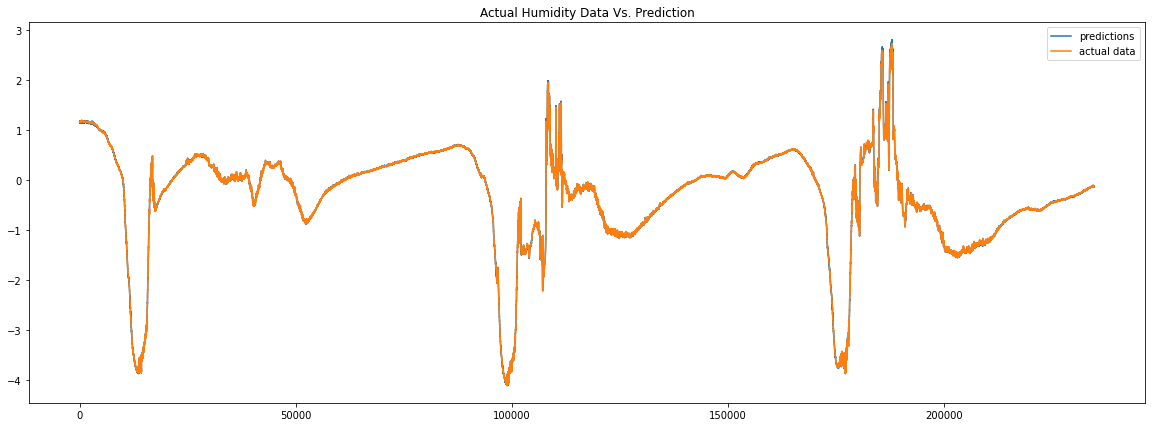

In [69]:
plt.figure(figsize=(20, 7))
plt.plot(test_preds[:,0], label = "predictions")
plt.plot(y_test[:,0], label = "actual data")
plt.legend()
plt.title('Actual Humidity Data Vs. Prediction')
plt.show()

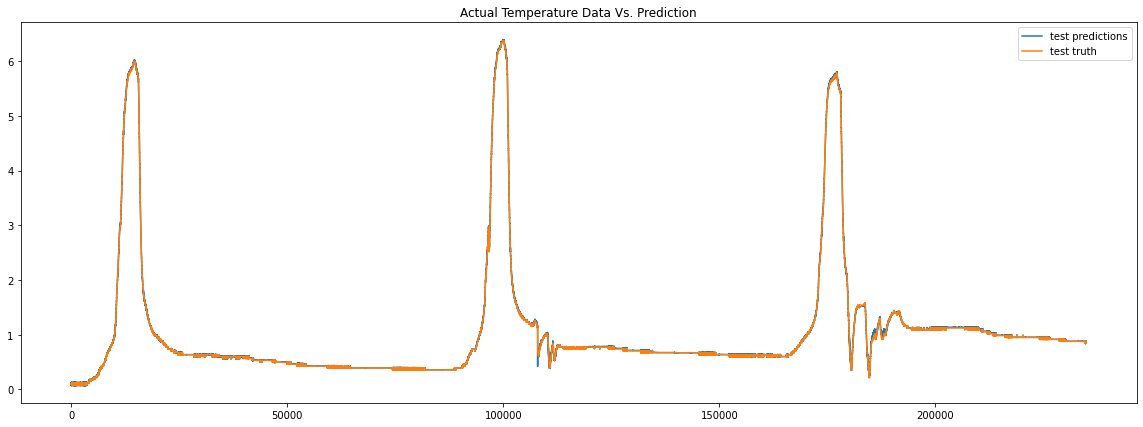

In [70]:
plt.figure(figsize=(20, 7))
plt.plot(test_preds[:,1], label = "test predictions")
plt.plot(y_test[:,1], label = "test truth")
plt.legend()
plt.title('Actual Temperature Data Vs. Prediction')
plt.show()

In [71]:
d = scaler.transform(data)
d = pd.DataFrame(index=data.index, data=d, columns=['Humidity', 'Temperature'])

In [72]:
d_pred = pd.DataFrame(index=data.index[-len(X_test):], data=test_preds, columns=['Humidity_pred', 'Temperature_pred'])

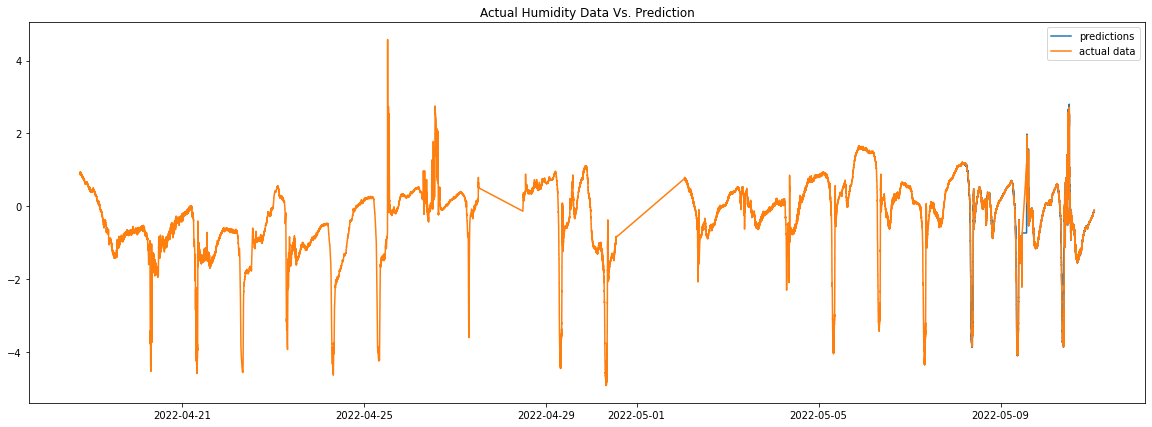

In [73]:
plt.figure(figsize=(20, 7))
plt.plot(d_pred.iloc[:,0], label = "predictions")
plt.plot(d.iloc[:,0], label = "actual data")
plt.legend()
plt.title('Actual Humidity Data Vs. Prediction')
plt.show()

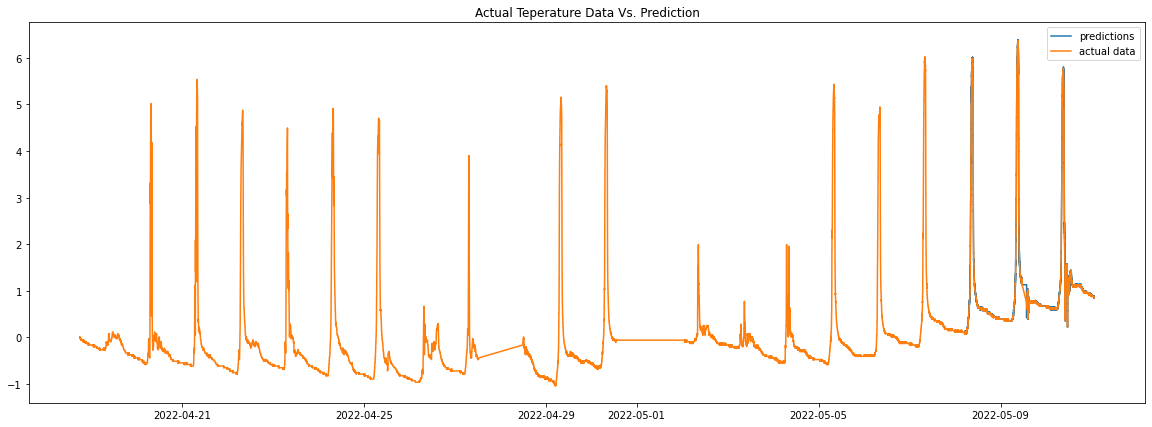

In [74]:
plt.figure(figsize=(20, 7))
plt.plot(d_pred.iloc[:,1], label = "predictions")
plt.plot(d.iloc[:,1], label = "actual data")
plt.legend()
plt.title('Actual Teperature Data Vs. Prediction')
plt.show()

# 05. Anomalies detection

## 05/ 1. PersistAD

L'approche PersistAD (Persistence Anomaly Detection) est une technique de détection d'anomalies qui utilise des données de séries chronologiques pour détecter les anomalies. Il se base sur le principe que les valeurs normales d'une série chronologique sont généralement proches des valeurs précédentes.

Pour détecter les anomalies dans les nouvelles données à l'aide de l'approche PersistAD, vous pouvez suivre les étapes suivantes :

1. Préparez les nouvelles données : Assurez-vous que les nouvelles données sont dans le même format que les données utilisées pour entraîner le modèle.

2. Calculez la distance entre les nouvelles données et les données précédentes : Utilisez une métrique de distance appropriée, comme la distance Euclidienne, pour calculer la distance entre les nouvelles données et les données précédentes pour chaque point de données.

3. Définir un seuil : Définissez un seuil pour déterminer quelles distances sont considérées comme anormales. Les distances supérieures à ce seuil sont considérées comme des anomalies.

Marquez les points de données comme anormaux : Marquez les points de données pour lesquels la distance est supérieure au seuil comme étant des anomalies.

Il existe des méthodes pour rendre le seuil de détection d'anomalie adaptatif en fonction de la situation. L'une des méthodes les plus courantes est d'utiliser des statistiques sur les données pour déterminer automatiquement un seuil approprié.

Par exemple, on peut utiliser la méthode de détection d'anomalies basée sur la distribution, qui consiste à utiliser la moyenne et l'écart-type de nos données pour déterminer un seuil approprié. on peut considérer toute valeur qui est supérieure à un certain nombre d'écart-types de la moyenne comme une anomalie.

on va utiliser la fenêtre glissante pour calculer la moyenne et l'écart-type partiel et relatif pour les 5 dernières données entrées.


In [93]:
X_test[155055]

array([[0.17523528, 0.60073964],
       [0.17523528, 0.60073964],
       [0.17523528, 0.60073964],
       [0.17523528, 0.60073964],
       [0.17523528, 0.63551024],
       [0.17523528, 0.63551024],
       [0.19020785, 0.63551024],
       [0.19020785, 0.63551024],
       [0.17523528, 0.63551024],
       [0.17523528, 0.63551024]])

In [94]:
new_data = X_test[155055]
Humidity_mean = new_data[:,0].mean()
Humidity_std = new_data[:,0].std()

temperature_mean = new_data[:,1].mean()
temperature_std = new_data[:,1].std()

In [95]:
print(f'Humidity mean = {Humidity_mean}, \nHumidity std = {Humidity_std}')
print(f'Temperature mean = {temperature_mean}, \nTemperature std = {temperature_std}')

Humidity mean = 0.17822979508613207, 
Humidity std = 0.00598902969684364
Temperature mean = 0.6216020004170376, 
Temperature std = 0.01703404641877226


In [ ]:
# Define the threshold as a number of standard deviations from the mean
# Humidity_threshold = Humidity_mean + 3 * Humidity_std
# Temperature_threshold = temperature_mean + 3 * temperature_std

In [ ]:
# print(Humidity_threshold, Temperature_threshold)

In [96]:
X_test.shape

(234827, 10, 2)

In [97]:
new_data.shape

(10, 2)

In [98]:
new_data = new_data.reshape(-1, X_test.shape[1], X_test.shape[2])
new_data.shape

(1, 10, 2)

In [99]:
new_data

array([[[0.17523528, 0.60073964],
        [0.17523528, 0.60073964],
        [0.17523528, 0.60073964],
        [0.17523528, 0.60073964],
        [0.17523528, 0.63551024],
        [0.17523528, 0.63551024],
        [0.19020785, 0.63551024],
        [0.19020785, 0.63551024],
        [0.17523528, 0.63551024],
        [0.17523528, 0.63551024]]])

In [100]:
pred = m.predict(new_data)
pred

1/1 [==============================] - 0s 140ms/step


array([[0.1787505, 0.63881  ]], dtype=float32)

In [101]:
# Get the temperature prediction for the single value
Humidity_prediction = pred[0][0]
Temperature_prediction = pred[0][1]

In [102]:
Humidity_prediction, Temperature_prediction

(0.1787505, 0.63881)

In [103]:
temperature_mean - 2 *(temperature_std + 0.001), Temperature_prediction, temperature_mean + 2 * (temperature_std + 0.001)

(0.5855339075794931, 0.63881, 0.6576700932545821)

**On va adopter cette approche qui va tolérer une faute de -+ de la prédiction des valeurs de l'humidité et la température de la 11ième timestep récolté par l'objet connecté.**

In [ ]:
# Temperature_prediction - 2 *(temperature_std + 0.001), next_timestep_actual_data_from_IOT_Object, Temperature_prediction + 2 * (temperature_std + 0.001)

#### la fonction qui permet de faire la détection d'anomalie

In [104]:
def is_anomalie(new_data, next_timestep_actual_data):

    Humidity_mean = new_data[:,0].mean()
    Humidity_std = new_data[:,0].std()

    temperature_mean = new_data[:,1].mean()
    temperature_std = new_data[:,1].std()

    new_data = new_data.reshape(-1, X_test.shape[1], X_test.shape[2])
    pred = m.predict(new_data)

    # Get the temperature prediction for the single value
    Humidity_prediction = pred[0][0]
    Temperature_prediction = pred[0][1]

    Not_Humidity_anomaly = Humidity_prediction - 3 * (Humidity_std+ 0.01)< next_timestep_actual_data[0]< Humidity_prediction + 3 * (Humidity_std+ 0.01)
    Not_Temperature_anomaly = Temperature_prediction - 3 *(temperature_std + 0.01)< next_timestep_actual_data[1]< Temperature_prediction + 3 * (temperature_std + 0.01)

    # Print the result
    if not Not_Humidity_anomaly:
      # on va seulement enregistrer les valeurs récolter par IOT object.
      # le processus d'envoie du message d'alert d'anomalie.
        print("Humidity anomaly detected!")
    else:
        print("Humidity is normal.")


    # Print the result
    if not Not_Temperature_anomaly:
        print("Temperature anomaly detected!")
    else:
        print("Temperature is normal.")

In [105]:
X_test[155055]

array([[0.17523528, 0.60073964],
       [0.17523528, 0.60073964],
       [0.17523528, 0.60073964],
       [0.17523528, 0.60073964],
       [0.17523528, 0.63551024],
       [0.17523528, 0.63551024],
       [0.19020785, 0.63551024],
       [0.19020785, 0.63551024],
       [0.17523528, 0.63551024],
       [0.17523528, 0.63551024]])

In [106]:
y_test[155055]

array([0.17523528, 0.60073964])

In [107]:
is_anomalie(X_test[155055], y_test[155055])

1/1 [==============================] - 0s 67ms/step
Humidity is normal.
Temperature is normal.


In [108]:
is_anomalie(X_test[155055], y_test[155055])

1/1 [==============================] - 0s 64ms/step
Humidity is normal.
Temperature is normal.


In [109]:
is_anomalie(X_test[-1], y_test[-1])

1/1 [==============================] - 0s 19ms/step
Humidity is normal.
Temperature is normal.


In [111]:
is_anomalie(X_test[-1], y_test[13000])

1/1 [==============================] - 0s 19ms/step
Humidity anomaly detected!
Temperature anomaly detected!


#### générer une anomalie

In [112]:
is_anomalie(X_test[10000], y_test[10000])

1/1 [==============================] - 0s 17ms/step
Humidity is normal.
Temperature is normal.


In [113]:
y_test[10000]

array([-0.00443561,  0.98321626])

In [114]:
anomalie_10000 = y_test[10000]
anomalie_10000[1] = 5.00911802

In [115]:
is_anomalie(X_test[10000], anomalie_10000)

1/1 [==============================] - 0s 25ms/step
Humidity is normal.
Temperature anomaly detected!


In [118]:
# def get_anomalies(new_data, y):

#   Humidity_stds = []
#   temperature_stds = []
#   Humidity_Temperature_predictions = []

#   for i in range(len(new_data)):
#     Humidity_stds.append(new_data[i][:,0].std())
#     temperature_stds.append(new_data[i][:,1].std())
#     newdata = new_data[i].reshape(-1, 10, 2)
#     pred = m.predict(newdata)
#     Humidity_Temperature_predictions.append((pred[0][0], pred[0][1]))


#   Humidity_anomalies    = []
#   Temperature_anomalies = []
#   for i ,h, t in enumerate(Humidity_Temperature_predictions):
#       Humidity_anomalies.append(h - 3 * (Humidity_stds[i]+ 0.01)< y[i][0]< h + 3 * (Humidity_stds[i]+ 0.01))
#       Temperature_anomalies.append(t - 3 * (temperature_stds[i]+ 0.01)< y[i][1]< t + 3 * (temperature_stds[i]+ 0.01))

#   return Humidity_anomalies, Temperature_anomalies